# Discrete gesture decoder evaluation

In [ ]:
%pip install torch==2.2.2 pytorch-lightning==1.8.6 hydra-core==1.3.2 omegaconf==2.3.0 seaborn

In [3]:
%pip install python-levenshtein

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/fa/8e/3c215e860b458cfbedb3ed73bc72e98eb7e0ed72f6b48099604a7a3260c2/rapidfuzz-3.14.3-cp312-cp312-macosx_10_13_x86_64.whl (1.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [python-levenshtein]
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install unidecode

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install --force-reinstall --no-cache-dir "numpy<2" numba==0.60.0

In [ ]:
%pip install -e ..

In [1]:
import sys

for name in [n for n in list(sys.modules) if n.startswith("numpy")]:
    del sys.modules[name]

import numpy as np
print(sys.executable)
print(np.__version__)
print(np.__file__)

/Users/chenee/homebrew/Caskroom/miniforge/base/bin/python
1.26.4
/Users/chenee/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/__init__.py


In [2]:
import os
import torch
from pytorch_lightning import Trainer
from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
from matplotlib import pyplot as plt
import seaborn as sns

from generic_neuromotor_interface.cler import GestureType, compute_cler
from generic_neuromotor_interface.data import make_dataset

TASK_NAME = "discrete_gestures"
EMG_DATA_DIR = "/Users/chenee/emg_data"  # path to EMG data
MODELS_DIR = "/Users/chenee/emg_models"  # path to model files

/Users/chenee/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/lightning_lite/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/Users/chenee/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Data Subset and Model Files

Before running this notebook, make sure you have downloaded the data (small subset) and model checkpoint.

You can do so with the following cell:

In [3]:
# Equivalent to README instructions.

from generic_neuromotor_interface.scripts.download_data import download_data
from generic_neuromotor_interface.scripts.download_models import download_models

if not os.path.exists(os.path.expanduser(EMG_DATA_DIR)):
    download_data(TASK_NAME, "small_subset", EMG_DATA_DIR)

if not os.path.exists(os.path.expanduser(MODELS_DIR)):
    download_models(TASK_NAME, MODELS_DIR)

In [4]:
if not os.path.exists(os.path.expanduser(EMG_DATA_DIR)):
    raise FileNotFoundError(f"The EMG data path does not exist: {EMG_DATA_DIR}")

if not os.path.exists(os.path.expanduser(MODELS_DIR)):
    raise FileNotFoundError(f"The models path does not exist: {MODELS_DIR}")

## Load model config

In [5]:
"""Load model config"""

config_path = os.path.join(os.path.expanduser(MODELS_DIR), TASK_NAME, "model_config.yaml")
config = OmegaConf.load(config_path)

## Load model checkpoint

In [6]:
"""Load model checkpoint"""

model_ckpt_path = os.path.join(
    os.path.expanduser(MODELS_DIR),
    TASK_NAME,
    "model_checkpoint.ckpt"
)
model = instantiate(config.lightning_module)
model = model.load_from_checkpoint(
    model_ckpt_path,
    map_location=torch.device("cpu"),
)

/Users/chenee/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['network'])`.
  rank_zero_warn(


## Instantiate data module

In [7]:
"""Assemble the data module"""

# Update DataModule config with data path
config["data_module"]["data_location"] = os.path.expanduser(EMG_DATA_DIR)
if "from_csv" in config["data_module"]["data_split"]["_target_"]:
    config["data_module"]["data_split"]["csv_filename"] = os.path.join(
        os.path.expanduser(EMG_DATA_DIR),
        f"{TASK_NAME}_corpus.csv"
    )

datamodule = instantiate(config["data_module"])

## Run inference on one test dataset

In [8]:
"""Grab one test dataset"""

test_dataset = make_dataset(
    datamodule.data_location,
    partition_dict={"discrete_gestures_user_002_dataset_000": None},  # from discrete_gestures_mini_split.yaml
    transform=datamodule.transform,
    emg_augmentation=None,
    window_length=None,
    stride=None,
    jitter=False,
)

sample = test_dataset[0]

[setup] Loading datasets for split None: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


In [9]:
"""Run inference"""

model.eval()

# unpack sample
emg = sample["emg"]
emg_times = sample["timestamps"]
labels = sample["prompts"]

# compute model outputs
with torch.no_grad():
    logits = model(emg.unsqueeze(0))

logits = logits[0]
    
# convert logits to probabilities
probs = torch.nn.Sigmoid()(logits)

# get timestamps associated with each predicted probability
prob_times = emg_times[model.network.left_context::model.network.stride]

In [10]:
"""Evaluate CLER"""

cler = compute_cler(probs, prob_times, labels)

print("CLER on this dataset:", cler)

CLER on this dataset: 0.13421496168030211


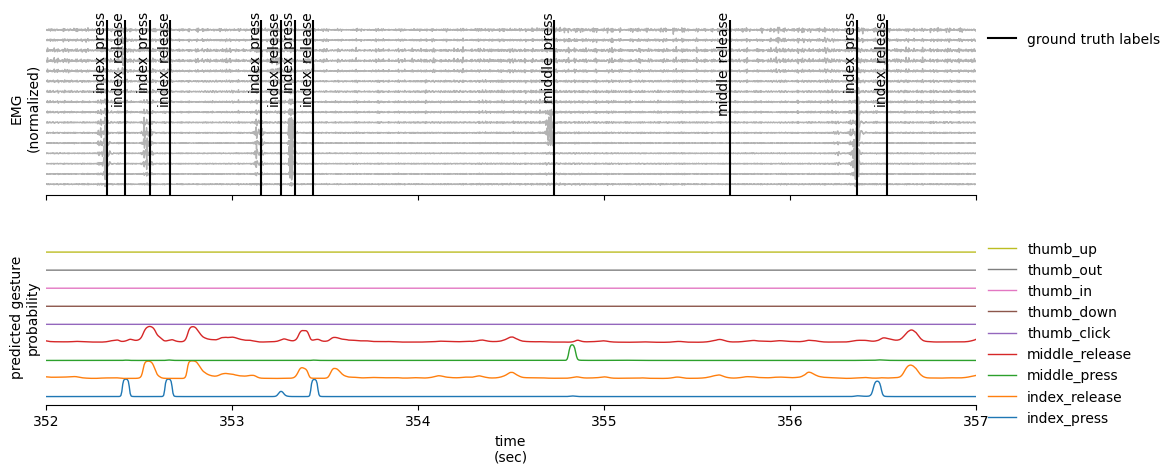

In [11]:
"""Plot predictions and targets"""

fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=False)

t0 = emg_times[0]

# plot EMG
ax = axes[0]
spacing = 200
for channel_index, channel_data in enumerate(emg):
    ax.plot(
        emg_times - t0,
        channel_data + channel_index * spacing,
        linewidth=1,
        color="0.7",
    )

ax.set_ylim([-spacing, len(emg) * spacing])
ax.set_yticks([])

sns.despine(ax=ax, left=True)
    
# labels
ax = axes[1]
for gesture in GestureType:
    prob_index = gesture.value
    ax.plot(
        prob_times - t0,
        probs[prob_index] + prob_index,
        linewidth=1,
        label=gesture.name
    )

ax.set_yticks([])

sns.despine(ax=ax, left=True)

legends, handles = ax.get_legend_handles_labels()
ax.legend(
    legends[::-1],
    handles[::-1],
    loc="upper left",
    ncols=1,
    bbox_to_anchor=(1.0, 1.0),
    frameon=False
)

ax.set_xlim([352, 357])

axes[0].set_ylabel("EMG\n(normalized)")
axes[1].set_ylabel("predicted gesture\nprobability")
axes[1].set_xlabel("time\n(sec)")


tmin, tmax = ax.get_xlim()
_, ymax = axes[0].get_ylim()

labels_in_window = False

for label in labels.to_dict(orient="records"):
    gesture_name = label["name"]
    t = label["time"] - t0
    if (t > tmin) and (t < tmax):
        labels_in_window = True
        lines = axes[0].axvline(t, color="k")
        axes[0].text(
            t - 0.075,
            ymax + 200,
            gesture_name,
            rotation="vertical",
            va="top",
            ha="left"
        )

if labels_in_window:
    axes[0].legend(
        [lines],
        ["ground truth labels"],
        loc="upper left",
        ncols=1,
        bbox_to_anchor=(1.0, 1.0),
        frameon=False,
    )

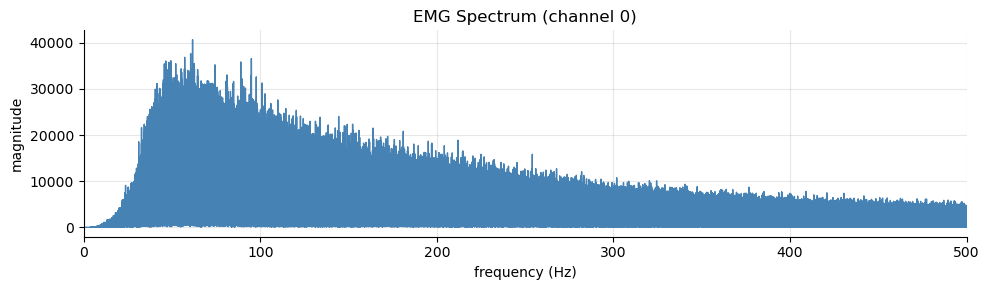

In [19]:
"""Plot EMG frequency-domain spectrum (one channel)"""
import numpy as np

# select one channel (0) and convert to numpy
emg_np = emg.detach().cpu().numpy() if hasattr(emg, "detach") else np.asarray(emg)
ch0 = emg_np[0]

# estimate sampling rate from timestamps
dt = np.median(np.diff(emg_times))
fs = 1.0 / dt if dt > 0 else 2000.0

# apply Hann window
window = np.hanning(len(ch0))
xw = ch0 * window

# FFT (magnitude)
freqs = np.fft.rfftfreq(len(xw), d=1.0 / fs)
spec = np.abs(np.fft.rfft(xw))

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(freqs, spec, color="steelblue", linewidth=1)
ax.set_xlim(0, 500)
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("magnitude")
ax.set_title("EMG Spectrum (channel 0)")
ax.grid(alpha=0.3)
sns.despine(ax=ax)
plt.tight_layout()
plt.show()

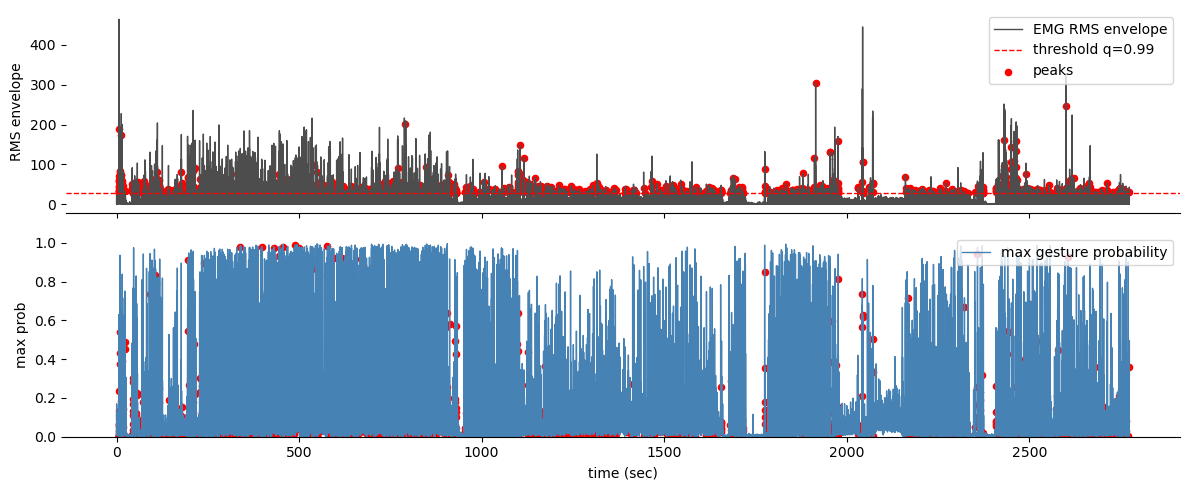

In [20]:
"""Peak detection vs gesture probabilities (time-domain)"""
import numpy as np

# parameters
peak_quantile = 0.99
min_peak_distance_sec = 0.15  # seconds

# convert emg to numpy and compute envelope (RMS over channels)
emg_np = emg.detach().cpu().numpy() if hasattr(emg, "detach") else np.asarray(emg)
emg_t = emg_times
env = np.sqrt(np.mean(emg_np**2, axis=0))  # (T,)

# threshold by quantile
thr = np.quantile(env, peak_quantile)

# find local maxima above threshold
dt = np.median(np.diff(emg_t))
min_peak_distance = int(max(1, min_peak_distance_sec / dt))
peaks = []
last_idx = -min_peak_distance
for i in range(1, len(env) - 1):
    if env[i] > thr and env[i] >= env[i-1] and env[i] >= env[i+1]:
        if i - last_idx >= min_peak_distance:
            peaks.append(i)
            last_idx = i

# plot envelope + peaks + probabilities (max over classes)
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

axes[0].plot(emg_t - emg_t[0], env, color="0.3", linewidth=1, label="EMG RMS envelope")
axes[0].axhline(thr, color="red", linestyle="--", linewidth=1, label=f"threshold q={peak_quantile:.2f}")
axes[0].scatter((emg_t[peaks] - emg_t[0]), env[peaks], color="red", s=20, label="peaks")
axes[0].set_ylabel("RMS envelope")
axes[0].legend(loc="upper right")
sns.despine(ax=axes[0], left=True)

# probability summary: max over classes at each prob time
prob_times_rel = prob_times - emg_t[0]
probs_np = probs.detach().cpu().numpy() if hasattr(probs, "detach") else np.asarray(probs)
prob_max = np.max(probs_np, axis=0)
axes[1].plot(prob_times_rel, prob_max, color="steelblue", linewidth=1, label="max gesture probability")
axes[1].set_ylabel("max prob")
axes[1].set_xlabel("time (sec)")
axes[1].set_ylim(0, 1.05)
axes[1].legend(loc="upper right")
sns.despine(ax=axes[1], left=True)

# mark peaks on probability plot (nearest prob time)
if len(peaks) > 0:
    peak_times = emg_t[peaks] - emg_t[0]
    # find nearest indices in prob_times for each peak
    idxs = np.searchsorted(prob_times_rel, peak_times, side="left")
    idxs = np.clip(idxs, 0, len(prob_times_rel) - 1)
    axes[1].scatter(prob_times_rel[idxs], prob_max[idxs], color="red", s=20, label="peaks")

plt.tight_layout()
plt.show()

## Evaluate full test set

Note that this requires you to have downloaded the full dataset (uncomment the below lines).

In [ ]:
## Uncomment to download the full dataset

# from generic_neuromotor_interface.scripts.download_data import download_data
# download_data(TASK_NAME, "full_data", EMG_DATA_DIR)

In [ ]:
trainer = Trainer(accelerator="cpu")
test_results = trainer.test(model=model, datamodule=datamodule)